In [1]:
import os
import torch
import torch.utils.data
import pytorch_lightning
from torch.utils.data import Dataset
from torchvision.io import read_video
import cv2
from torch.utils.data import random_split
import random
from torch.utils.data import Subset
from torchvision.io import VideoReader

import cv2

def load_video_with_opencv(video_path):
    vid = cv2.VideoCapture(video_path)
    frames = []
    while True:
        ret, frame = vid.read()
        if not ret:
            break
        # Convertir en niveaux de gris (même si c'est déjà le cas)
        gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        frames.append(torch.tensor(gray_frame))
    vid.release()
    video_tensor = torch.stack(frames)
    return video_tensor.unsqueeze(1)  # Ajoute un canal


class VideoDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        Args:
        - root_dir (string): Dossier avec toutes les vidéos.
        - transform (callable, optional): Transformation optionnelle à appliquer
            sur une vidéo.
        """
        self.root_dir = root_dir
        self.transform = transform

        self.classes = os.listdir(root_dir)
        self.classes.sort()
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}

        self.video_list = []
        for cls_name in self.classes:
            cls_dir = os.path.join(root_dir, cls_name)
            for video_name in os.listdir(cls_dir):
                self.video_list.append((os.path.join(cls_dir, video_name), self.class_to_idx[cls_name]))

    def __len__(self):
        return len(self.video_list)

    def __getitem__(self, idx):
        video_path, label = self.video_list[idx]
        
        # Charger uniquement le flux vidéo (et ignorer l'audio et les timestamps)
        video = load_video_with_opencv(video_path)

        # S'assurer que la vidéo est sur le GPU si disponible
        if torch.cuda.is_available():
            video = video.to("cuda:0")
        
        if self.transform:
            video = self.transform(video)

        return video, label
    

class VideoDataModule(pytorch_lightning.LightningDataModule):

    # Configuration du Dataset
    _DATA_PATH = "C:/Users/mcouv/Work/machine-learning/ML_tuto/classes"
    _BATCH_SIZE = 4
    _NUM_WORKERS = 0  # Nombre de processus parallèles récupérant les données

    def __init__(self, transform=None):
        super(VideoDataModule, self).__init__()
        self.transform = transform

    def setup(self, stage=None):
        # Initialiser le dataset avec la transformation
        video_dataset = VideoDataset(root_dir=self._DATA_PATH, transform=self.transform)

        # La logique de séparation train/test est déjà définie dans le code donné, donc on la réutilise ici.
        train_indices = []
        test_indices = []

        # Pour chaque classe, récupérez les indices de ses vidéos.
        for cls_name in video_dataset.classes:
            cls_indices = [i for i, (path, label) in enumerate(video_dataset.video_list) if label == video_dataset.class_to_idx[cls_name]]
            
            # Mélangez ces indices.
            random.shuffle(cls_indices)
            
            # Séparez-les en fonction des ratios d'entraînement et de test.
            cls_train_size = int(0.8 * len(cls_indices))
            train_indices.extend(cls_indices[:cls_train_size])
            test_indices.extend(cls_indices[cls_train_size:])

        # Créez des sous-ensembles d'entraînement et de test en utilisant ces indices.
        self.train_dataset = Subset(video_dataset, train_indices)
        self.test_dataset = Subset(video_dataset, test_indices)

    def train_dataloader(self):
        """
        Créer le DataLoader pour le partition d'entraînement
        """
        return torch.utils.data.DataLoader(
            self.train_dataset,
            batch_size=self._BATCH_SIZE,
            num_workers=self._NUM_WORKERS,
            shuffle=True,
        )

    def val_dataloader(self):
        """
        Créer le DataLoader pour le partition de validation
        """
        return torch.utils.data.DataLoader(
            self.test_dataset,
            batch_size=self._BATCH_SIZE,
            num_workers=self._NUM_WORKERS,
            shuffle=False,
        )


In [2]:
from torch.utils.data import DataLoader
import cv2
from torch.utils.data import random_split
import random
from torch.utils.data import Subset
import numpy as np
import torchvision.transforms.functional as F
from torchvision import transforms



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def uniform_frame_sampling(video_tensor, target_frames=90):
    """
    Sélectionne un nombre uniformément distribué de frames pour que toutes les vidéos aient la même taille.

    Args:
        video_tensor (torch.Tensor): La vidéo originale de forme (T, C, H, W)
        target_frames (int): Nombre de frames cibles à obtenir

    Returns:
        torch.Tensor: Vidéo échantillonnée de forme (target_frames, C, H, W)
    """

    # Obtenir le nombre actuel de frames
    current_frames = video_tensor.shape[0]

    # Si la vidéo actuelle a exactement le nombre cible de frames, la renvoyer telle quelle
    if current_frames == target_frames:
        return video_tensor

    # Calculer les indices des frames à échantillonner
    indices = torch.linspace(0, current_frames - 1, target_frames).long()

    return video_tensor[indices]

# Pour l'utiliser dans le VideoDataset :


def video_resize_and_sample(video_tensor, size=(8, 16), T=90):
    # Resize
    transform = transforms.Resize(size, antialias=False)

    resized_video = [transform(frame) for frame in video_tensor]
    resized_video_tensor = torch.stack(resized_video)
    
    # Uniform sampling
    sampled_video_tensor = uniform_frame_sampling(resized_video_tensor, T)
    
    # Normalisation entre [-1, 1]
    normalized_tensor = (sampled_video_tensor / 127.5) - 1.0

    return normalized_tensor.to(device)


Taille de l'ensemble d'entraînement: 227
Taille de l'ensemble de validation: 57
Forme d'un batch de vidéos: (4, 90, 1, 8, 16)
Forme d'un batch de labels: (4,)


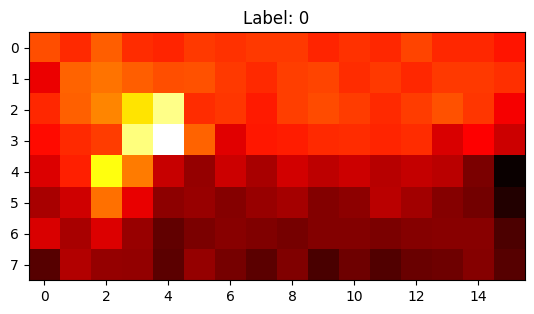

In [3]:
import matplotlib.pyplot as plt

# Initialisation du VideoDataModule avec la transformation désirée
transform = video_resize_and_sample
video_data_module = VideoDataModule(transform=transform)
video_data_module.setup()

# Obtenir les chargeurs de données :
train_loader = video_data_module.train_dataloader()
val_loader = video_data_module.val_dataloader()

# Afficher des informations générales
print(f"Taille de l'ensemble d'entraînement: {len(train_loader.dataset)}")
print(f"Taille de l'ensemble de validation: {len(val_loader.dataset)}")

# Obtenir un batch de données et afficher ses dimensions
videos_gpu, labels_gpu = next(iter(train_loader))
videos = videos_gpu.cpu().numpy()
labels = labels_gpu.cpu().numpy()

print(f"Forme d'un batch de vidéos: {videos.shape}")  # devrait être de la forme (batch_size, T, C, H, W)
print(f"Forme d'un batch de labels: {labels.shape}") 

# Afficher un extrait d'une frame
plt.imshow(videos[0, 0, 0], cmap='hot')
plt.title(f"Label: {labels[0]}")
plt.show()

# Compter le nombre de vidéos par classe dans l'ensemble d'entraînement
# class_counts = {}
# for _, label in train_loader.dataset:
#     class_name = video_data_module.train_dataset.dataset.classes[label]
#     class_counts[class_name] = class_counts.get(class_name, 0) + 1

# print("Nombre de vidéos par classe dans l'ensemble d'entraînement:")
# for cls, count in class_counts.items():
#     print(f"{cls}: {count}")

# Si vous souhaitez afficher des statistiques supplémentaires, vous pouvez étendre ce script.


In [29]:

import torch
import torch.nn as nn
import torch.nn.functional as F
import pytorchvideo.models.resnet
import os
import pytorch_lightning
import pytorchvideo.data
import torch.utils.data

def make_kinetics_resnet():
  return pytorchvideo.models.resnet.create_resnet(
    input_channel=1,
    model_depth=50,  # Choix arbitraire, pourrait être modifié selon les besoins.
    model_num_class=2,  # Classification binaire.
    stem_conv_kernel_size=(3, 3, 3),
    stem_conv_stride=(1, 1, 1),
    stem_pool_kernel_size=(1, 2, 2),
    stem_pool_stride=(1, 2, 2),
    head_pool_kernel_size=(4, 2, 2),
)


class VideoClassificationLightningModule(pytorch_lightning.LightningModule):
  def __init__(self):
      super().__init__()
      self.model = SimpleVideoNet().to("cuda:0")

  def forward(self, x):
      return self.model(x)

  def training_step(self, batch, batch_idx):
      # The model expects a video tensor of shape (B, C, T, H, W), which is the
      # format provided by the dataset
      y_hat = self.model(batch[0].permute(0, 2, 1, 3, 4))

      # Compute cross entropy loss, loss.backwards will be called behind the scenes
      # by PyTorchLightning after being returned from this method.
      loss = F.cross_entropy(y_hat, batch[1])

      # Log the train loss to Tensorboard
      self.log("train_loss", loss.item())

      return loss

  def validation_step(self, batch, batch_idx):
    y_hat = self.model(batch[0].permute(0, 2, 1, 3, 4))
    loss = F.cross_entropy(y_hat, batch[1])
    self.log("val_loss", loss)
    return loss

  def configure_optimizers(self):
      """
      Setup the Adam optimizer. Note, that this function also can return a lr scheduler, which is
      usually useful for training video models.
      """
      return torch.optim.Adam(self.parameters(), lr=1e-1)


In [5]:

import torch.nn as nn

class VideoClassifier(nn.Module):
    def __init__(self):
        super(VideoClassifier, self).__init__()
        
        # La couche d'entrée attend des vidéos de la forme (C, T, H, W) = (1, 90, 8, 16)
        self.conv_layer1 = nn.Sequential(
            nn.R2(1, 32, kernel_size=(3, 3, 3), padding=1),  # 3D convolution
            nn.LeakyReLU(),
            nn.MaxPool3d(kernel_size=(2, 2, 2))
        )
        
        self.conv_layer2 = nn.Sequential(
            nn.Conv3d(32, 64, kernel_size=(3, 3, 3), padding=1),
            nn.LeakyReLU(),
            nn.MaxPool3d(kernel_size=(2, 2, 2))
        )
        
        # Ici, on aplatit la sortie pour la connecter à des couches entièrement connectées
        self.fc1 = nn.Linear(64 * 22 * 2 * 4, 512)  # La taille dépend de la sortie du dernier MaxPool3d
        self.fc2 = nn.Linear(512, 1)  # 1 neurone en sortie pour une classification binaire
        
    def forward(self, x):
        x = self.conv_layer1(x)
        x = self.conv_layer2(x)
        x = x.view(x.size(0), -1)  # flatten
        x = nn.LeakyReLU()(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))

In [6]:
def train():
    classification_module = VideoClassificationLightningModule()
    video_data_module = VideoDataModule(transform=transform)
    video_data_module.setup()
    trainer = pytorch_lightning.Trainer(max_epochs=10, )
    trainer.fit(classification_module, video_data_module)

In [7]:
class SimpleVideoNet(nn.Module):
    def __init__(self, num_classes=2):
        super(SimpleVideoNet, self).__init__()

        # Stem
        self.stem = nn.Sequential(
            nn.Conv3d(1, 32, kernel_size=(3, 3, 3), stride=(3, 3, 3), padding=(3, 3, 3)), # Convolutions 3D
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2)) # Pooling 3D
        )

        # Backbone - Simple Conv Layers (you can replace with ResBlocks or MobileNet blocks for better performance)
        self.backbone = nn.Sequential(
            nn.Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1)),
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))
        )

        # Head
        self.head = nn.Sequential(
            nn.AdaptiveAvgPool3d((1, 1, 1)), # Pooling temporel + spatial
            nn.Flatten(),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        x = self.stem(x)
        x = self.backbone(x)
        x = self.head(x)
        return x


In [8]:
# Création du modèle
model = SimpleVideoNet()

# Simulation d'un batch de données d'entrée
input_tensor = torch.randn(8, 1, 90, 8, 16)

# Passage du batch à travers le modèle
output = model(input_tensor)

# Affichage de la sortie
print(output.shape)  # Devrait afficher torch.Size([8, 2])


torch.Size([8, 2])


In [9]:
torch.set_float32_matmul_precision('medium')
classification_module = VideoClassificationLightningModule()
video_data_module = VideoDataModule(transform=transform)
video_data_module.setup()
trainer = pytorch_lightning.Trainer(max_epochs=10, log_every_n_steps=1)
trainer.fit(classification_module, video_data_module)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type           | Params
-----------------------------------------
0 | model | SimpleVideoNet | 56.4 K
-----------------------------------------
56.4 K    Trainable params
0         Non-trainable params
56.4 K    Total params
0.226     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

C:\Users\mcouv\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:442: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


C:\Users\mcouv\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 9: 100%|██████████| 57/57 [04:00<00:00,  4.22s/it, v_num=5]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 57/57 [04:00<00:00,  4.22s/it, v_num=5]


AttributeError: 'SimpleVideoNet' object has no attribute 'save'

In [17]:

torch.save(classification_module.state_dict(), "model.pth")

 Le volume dans le lecteur C s'appelle Windows
 Le num�ro de s�rie du volume est 92DF-69A0

 R�pertoire de c:\Users\mcouv\Work\machine-learning\ML_tuto\resNet3d

03/09/2023  20:44    <DIR>          .
03/09/2023  19:11    <DIR>          ..
03/09/2023  19:11    <DIR>          .ipynb_checkpoints
03/09/2023  13:18                 0 __init__.py
03/09/2023  19:07    <DIR>          __pycache__
03/09/2023  18:53             5�879 datamodule.py
03/09/2023  20:05    <DIR>          lightning_logs
03/09/2023  20:48           227�719 model.pth
03/09/2023  19:03             2�977 model.py
03/09/2023  18:54               717 train.py
03/09/2023  20:49            35�617 try_resnet.ipynb
03/09/2023  18:45             2�332 Untitled.ipynb
               7 fichier(s)          275�241 octets
               5 R�p(s)  255�212�912�640 octets libres


In [28]:
model = classification_module.model
val_dataloader = video_data_module.val_dataloader()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for batch in val_dataloader:
        # Je suppose que vos données sont sous forme (videos, labels)
        videos, labels = batch
        outputs = model(videos.permute(0, 2, 1, 3, 4))
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Accuracy of the model on the validation data: {accuracy}%")





RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!